## Brain Observatory Trace Analysis
This notebook demonstrates how to run the stimulus-specific tuning analysis code in the SDK.  First let's instantiate a `BrainObservatoryCache` instance.

Download this notebook in .ipynb format <a href='brain_observatory_analysis.ipynb'>here</a>.

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc =  BrainObservatoryCache(manifest_file='boc/manifest.json')

## Drifting Gratings
In this example, we'll show how you can plot a heatmap of a cell's response organized by orientation and temporal frequency.  Here we start with a known experiment ID.  Take a look at the other notebook to see how you can find experiments of interest.  You can run the drifting grating analysis code on that experiment's NWB file as follows:

In [2]:
###  Find experiment of interest  ###

experiment_containers = boc.get_experiment_containers(targeted_structures=['VISp'],
                                                     imaging_depths=[175],
                                                     cre_lines=['Cux2-CreERT2'])
experiment_container_id = experiment_containers[0]['id']

import allensdk.brain_observatory.stimulus_info as stim_info

# Find the experiment with the static static gratings stimulus
exp = boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id], 
                                stimuli=[stim_info.DRIFTING_GRATINGS])
print("Experiment with drifting gratings:")
exp

Experiment with drifting gratings:


[{'id': 501704220,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 104,
  'experiment_container_id': 511510736,
  'session_type': 'three_session_A',
  'donor_name': '222426',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
  'fail_eye_tracking': True}]

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from allensdk.brain_observatory.drifting_gratings import DriftingGratings

data_set = boc.get_ophys_experiment_data(501704220)
dg = DriftingGratings(data_set)

In [4]:
###  Find cell in the experiment  ###

experiment = boc.get_ophys_experiment_data(exp[0]['id']) 
experiment_cells_id = experiment.get_cell_specimen_ids()
print("number of cells:", len(experiment_cells_id))

experiment_cells_id
# scelgo la prima cellula

number of cells: 142


array([517474366, 517473341, 587377582, 517473255, 517471959, 587377204,
       517472645, 517472442, 517472724, 517472731, 517472399, 517472421,
       517472712, 517472300, 517473240, 517474437, 517472450, 587376723,
       517471794, 517472454, 517471803, 517471997, 587377211, 517472684,
       517472110, 517472379, 517473388, 517474012, 517472677, 517473514,
       517474020, 517473991, 517474002, 517473980, 517473967, 517474067,
       517472180, 587377006, 517471906, 587377570, 517471833, 517471841,
       517472416, 517471991, 517472903, 517472425, 517472900, 517472462,
       587377108, 517474415, 517472135, 587377167, 517473304, 517473332,
       517473313, 517471966, 517474121, 517474459, 517473080, 517474353,
       517473947, 517472203, 517472207, 517474451, 587377374, 517472141,
       587377552, 517472171, 517472470, 587377518, 517473596, 517472116,
       517473926, 517472438, 517472123, 517473957, 587377633, 587377673,
       587376680, 587377651, 517472892, 517473360, 

If you know which cell you're interested in, here's how you can find out where it is in the NWB File.

In [5]:
import numpy as np
specimen_id = experiment_cells_id[1]
cell_loc = data_set.get_cell_specimen_indices([specimen_id])[0]

print("Specimen ID:", specimen_id)
print("Cell loc:", cell_loc)

Specimen ID: 517473341
Cell loc: 1


The `response` property of the stimulus-specific analysis objects is 4-D array organized with the following dimensions:
    
    0: num. grating directions
    1: num. grating temporal frequencies + 1 (0=blank sweep)
    2: num. cells + 1 (running speed)
    3: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

Dimension 2 of the `response` array has one index per cell in the experiment, plus one.  The final index of that dimension is the running speed (`response[:,:,-1,:]`).  This organization allows users to examine whether the mouse ran more for some specific stimulus conditions.

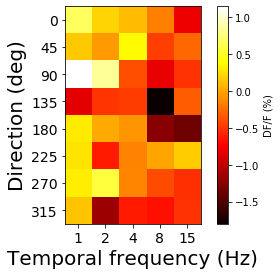

In [6]:
# skip the blank sweep column of the temporal frequency dimension
plt.imshow(dg.response[:,1:,cell_loc,0], cmap='hot', interpolation='none')
plt.xticks(range(5), dg.tfvals[1:])
plt.yticks(range(8), dg.orivals)
plt.xlabel("Temporal frequency (Hz)", fontsize=20)
plt.ylabel("Direction (deg)", fontsize=20)
plt.tick_params(labelsize=14)
cbar= plt.colorbar()
cbar.set_label("DF/F (%)")

In [7]:
dg.response[:,1:,cell_loc,0]

array([[ 0.66515454,  0.20813788,  0.10627922, -0.15753335, -0.79994538],
       [ 0.15656067, -0.04598996,  0.37704264, -0.44625186, -0.26728912],
       [ 1.14098522,  0.83358281, -0.38634747, -0.8152921 , -0.50689359],
       [-0.84436277, -0.49116664, -0.46296053, -1.79955557, -0.32198453],
       [ 0.3050655 ,  0.01860184, -0.07283553, -1.2425576 , -1.35294036],
       [ 0.26806394, -0.61308508, -0.1514161 , -0.00583429,  0.17593556],
       [ 0.31504664,  0.56704481, -0.13528015, -0.39482595, -0.52347839],
       [ 0.1331938 , -1.14545111, -0.61056148, -0.65117069, -0.50596552]])

The `peak` property of the analysis object is a Pandas DataFrame of peak conditions (direction and temporal frequency) as well as computed response metrics.  For drifting gratings this includes:

    ori_dg: preferred direction (index into dg.orivals)
    tf_dg: preferred temporal frequency (index into tf.tfvals)
    response_reliability_dg: response reliability 
    osi_dg: orientation selectivity index
    dsi_dg: direction selectivity index
    ptest_dg: number of signficant cells
    p_run_dg: K-S statistic comparing running trials to stationary trials
    run_modulation_dg: ratio of mean fluorescence during running vs static
    cv_dg: circular variance 

In [8]:
dg.peak.loc[cell_loc]

/home/laura/conda_projects/calcium_image/lib/python3.6/site-packages/allensdk/brain_observatory/drifting_gratings.py:191: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_os_dg.iloc[nc] = np.abs(CV_top_os.sum())/tuning.sum()
/home/laura/conda_projects/calcium_image/lib/python3.6/site-packages/allensdk/brain_observatory/drifting_gratings.py:192: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_ds_dg.iloc[nc] = np.abs(CV_top_ds.sum())/tuning.sum()
/home/laura/conda_projects/calcium_image/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


ori_dg                       2
tf_dg                        1
reliability_dg         0.02647
osi_dg                0.403344
dsi_dg                0.567253
peak_dff_dg            1.14099
ptest_dg             0.0119524
p_run_dg                   NaN
run_modulation_dg          NaN
cv_os_dg              0.189848
cv_ds_dg              0.252391
tf_index_dg            0.38428
cell_specimen_id     517473341
Name: 1, dtype: object

Next let's plot all trials for a given cell's preferred condition.

In [9]:
pref_ori = dg.orivals[dg.peak.ori_dg[cell_loc]]
pref_tf = dg.tfvals[dg.peak.tf_dg[cell_loc]]
print("Preferred direction:", pref_ori)
print("Preferred temporal frequency:", pref_tf)

Preferred direction: 90
Preferred temporal frequency: 1


In [10]:
pref_trials = dg.stim_table[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]
pref_trials

,temporal_frequency,orientation,blank_sweep,start,end
121,1.0,90.0,0.0,11677,11736
191,1.0,90.0,0.0,17999,18058
246,1.0,90.0,0.0,52773,52832
328,1.0,90.0,0.0,60179,60239
336,1.0,90.0,0.0,60901,60961
357,1.0,90.0,0.0,62798,62857
358,1.0,90.0,0.0,62888,62948
425,1.0,90.0,0.0,96937,96996
434,1.0,90.0,0.0,97749,97809
453,1.0,90.0,0.0,99465,99525


`sweep_response` is a DataFrame that contains the DF/F of each cell during each stimulus trial. It shares its index with `stim_table`. Each cell contains a timeseries that extends from 1 second prior to the start of the trial to 1 second after the end of the trial. The final column of `sweep_response`, named `dx`, is the running speed of the mouse during each trial. The data in this DataFrame is used to create another DataFrame called `mean_sweep_response` that contains the mean DF/F during the trial for each cell (and the mean running speed in the last column).

In [11]:
subset = dg.sweep_response[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]

In [12]:
subset.head() # colonne: cellule
              # righe: esperimenti

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,dx
121,"[-4.8875866, -1.136589, 6.204903, -2.7543187, ...","[-5.0853133, -4.90582, 5.181825, 2.6562333, -3...","[0.012254715, -4.896724, 3.8753152, 2.193272, ...","[-0.87007284, -1.5813768, -2.2911668, -2.76821...","[-1.9617558, 3.770566, -7.295889, 4.342389, -1...","[-8.032978, 1.6206622, -6.0463905, -1.0339975,...","[0.3709793, -9.89334, 7.9072, 4.8038244, -2.41...","[-10.448045, -1.8878698, -0.89867115, 1.747238...","[4.014635, -1.7489433, -4.429859, 4.8527837, -...","[1.7234802, -4.0372553, 3.5490632, -1.883471, ...",...,"[-3.572017, -6.855756, 0.036776066, 0.29084682...","[-5.0299463, -4.733062, -1.6422808, -0.387007,...","[2.9037118, -7.0212784, -1.9936144, -4.5736313...","[-5.3198156, 1.773274, 5.013907, -2.0209253, 0...","[0.8834958, -3.287363, -1.0445476, -5.941695, ...","[13.14404, -2.9632926, -0.5581796, -4.838884, ...","[4.724467, -4.939401, -0.57533383, 5.4159403, ...","[0.6125808, 4.006028, 3.1423569, 3.069234, -3....","[-1.7252088, -4.34016, -8.811063, -4.9664555, ...","[0.21748903393745422, -4.298713207244873, 4.01..."
191,"[6.5995216, -2.573204, 5.588138, -1.304543, -2...","[-0.51959157, 3.901875, -5.495268, 0.71964264,...","[3.321302, -2.549249, -6.856501, -5.676496, -0...","[1.4567494, -3.475386, -0.3843844, -1.3150692,...","[-2.4599254, -10.88571, -4.972047, -2.0627558,...","[3.4731984, -4.4142127, -5.55287, -0.35197735,...","[7.3698044, 10.085011, 7.053077, 11.381329, 11...","[1.1879563, -1.8295705, 0.001847744, -2.594822...","[-3.8113773, 2.9258966, -8.639824, 1.0671854, ...","[-2.4330437, -7.069421, -4.428321, 1.9696593, ...",...,"[4.3762326, -3.0170918, -5.5706205, 1.2163401,...","[-7.436138, 0.05699396, -4.286492, -5.906749, ...","[4.3248534, -3.206855, 3.0392528, 3.2877326, 6...","[-7.9491973, -0.34030676, 0.042903423, 1.94170...","[1.6995192, -4.3174925, 3.2733798, -2.443266, ...","[8.281719, 1.4686465, 1.3224721, -4.8154116, 3...","[-14.684629, -11.680693, -12.378508, -18.79794...","[14.002895, -16.257763, 1.9768357, -8.086234, ...","[3.6524177, 0.50867796, -1.1929333, -0.0531196...","[1.8649922609329224, 1.4237103462219238, -2.45..."
246,"[-4.310441, -0.7124722, 2.8398514, 5.9473634, ...","[-2.1737635, -4.8159304, 0.14086962, -4.689109...","[-7.6874733, 1.6942143, -9.117519, -6.565243, ...","[2.2342563, 4.8097014, 6.537533, -4.3124437, -...","[-1.1386096, -1.8846333, 0.82519054, 2.9646754...","[2.9808164, 1.233995, -2.5824785, -1.4739752, ...","[-8.81105, -3.78564, 3.3467531, 5.294752, -4.4...","[-0.68156123, -11.155134, 6.213987, 4.779148, ...","[2.7191997, -4.2651415, -5.8894157, -5.2296042...","[-6.7607403, -4.438859, -10.108972, -1.8388152...",...,"[-4.418129, -2.837801, 8.652067, -1.5974998, 1...","[-3.1793952, -2.3378491, -4.967904, -10.295301...","[4.992163, -7.723981, -2.7691543, -5.3283095, ...","[4.162371, 0.5904436, 0.7972002, 3.1405091, 0....","[2.7079701, 1.9562006, 5.65567, -1.1032045, 1....","[0.6529331, 7.383299, -10.182977, -1.3791442, ...","[0.09973049, -1.9394934, 1.2550354, 0.79693794...","[-3.3533633, 4.378402, 8.340001, -3.5506725, 1...","[-4.800087, 4.7591925, 6.4960957, -7.2532177, ...","[0.4056244492530823, -5.604191303253174, -1.06..."
328,"[4.1856527, -0.3305316, 9.467125, -3.6086738, ...","[0.79630613, 0.003194809, 1.8084645, -4.477495...","[2.4892807, -2.1263897, 9.541357, 7.7919126, -...","[-5.6467295, -8.008682, 0.2267003, 7.333839, -...","[3.317511, 1.2443185, -2.4102032, -6.02991, 4....","[-0.5851865, 1.6351342, -2.1215737, 4.175234, ...","[-0.35988688, 0.6507635, 0.44509172, 3.8901687...","[2.8666854, 5.438733, 11.4802475, -4.882908, 4...","[-3.5859346, 0.59137344, 2.718997, -8.688659, ...","[-3.6799848, -4.7292113, 0.36904812, 0.1898050...",...,"[1.2156248, 7.4522257, 0.9893775, -3.2477021, ...","[10.292816, -0.5925536, 1.104486, -4.455149, -...","[18.76626, 15.1754265, 9.272432, -2.1354496, 3...","[-4.1576624, -10.463494, 1.7631769, 4.2677045,...","[2.1909237, -0.1193583, -1.2126207, 4.241848, ...","[-6

In [13]:
subset['0'].loc[121]

array([-4.8875866e+00, -1.1365891e+00,  6.2049031e+00, -2.7543187e+00,
       -4.3477831e+00,  1.4337182e+00,  5.8850050e-01, -6.6632566e+00,
        6.6780925e+00, -1.3279319e-01, -1.7387986e+00,  6.2148809e+00,
       -1.1026859e-02,  5.6434870e-01, -2.9191792e+00,  1.9597888e+00,
        1.2474990e+01,  1.8564463e-01,  1.5266538e+00, -1.5139222e+00,
       -3.1273961e-01,  2.0947099e+00, -2.8745770e+00,  3.0785799e-01,
       -3.9115846e+00,  3.2072783e+00, -1.0567009e+00, -5.6518078e+00,
       -8.2681541e+00,  4.7396898e+00, -8.9388075e+00, -5.3615928e+00,
       -1.0262913e+01,  1.0016918e+00, -2.8128445e+00, -7.0235491e+00,
        1.8764138e+00, -2.2028863e+00,  9.8649263e-01,  1.1697161e+01,
        2.1647692e+00,  6.6897154e+00, -2.3737371e+00,  1.1752248e+00,
       -5.8747530e+00,  3.4823895e+00, -1.4614165e+00, -4.4486704e+00,
        1.2382388e+00, -2.9252231e+00,  1.0707617e+00,  7.5351477e+00,
        1.0611415e+00, -4.0399370e+00, -1.7556071e+00,  9.3467236e-01,
      

Here we look at the mean running speed during trials that presented the preferred condition.

In [14]:
subset_mean = dg.mean_sweep_response[(dg.stim_table.orientation==pref_ori)&
                                     (dg.stim_table.temporal_frequency==pref_tf)]
subset_mean['dx']

121    0.027348
191    0.022810
246   -0.015181
328    0.013787
336    0.035902
357    0.008218
358    0.009195
425   -0.020195
434   -0.009954
453   -0.002959
476   -0.012238
479   -0.023450
543    0.052230
612    7.118769
618    6.481082
Name: dx, dtype: float64

In [13]:
#subset_mean

In [14]:
#exp_num = 73
#subset.loc[exp_num]['0']
#plt.plot(np.arange(len(subset.loc[exp_num]['0'])), subset['0'].loc[exp_num])

In [15]:
trial_timestamps = np.arange(-1*dg.interlength, dg.interlength+dg.sweeplength, 1.)/dg.acquisition_rate
trial_timestamps 

array([-0.9972 , -0.96396, -0.93072, -0.89748, -0.86424, -0.831  ,
       -0.79776, -0.76452, -0.73128, -0.69804, -0.6648 , -0.63156,
       -0.59832, -0.56508, -0.53184, -0.4986 , -0.46536, -0.43212,
       -0.39888, -0.36564, -0.3324 , -0.29916, -0.26592, -0.23268,
       -0.19944, -0.1662 , -0.13296, -0.09972, -0.06648, -0.03324,
        0.     ,  0.03324,  0.06648,  0.09972,  0.13296,  0.1662 ,
        0.19944,  0.23268,  0.26592,  0.29916,  0.3324 ,  0.36564,
        0.39888,  0.43212,  0.46536,  0.4986 ,  0.53184,  0.56508,
        0.59832,  0.63156,  0.6648 ,  0.69804,  0.73128,  0.76452,
        0.79776,  0.831  ,  0.86424,  0.89748,  0.93072,  0.96396,
        0.9972 ,  1.03044,  1.06368,  1.09692,  1.13016,  1.1634 ,
        1.19664,  1.22988,  1.26312,  1.29636,  1.3296 ,  1.36284,
        1.39608,  1.42932,  1.46256,  1.4958 ,  1.52904,  1.56228,
        1.59552,  1.62876,  1.662  ,  1.69524,  1.72848,  1.76172,
        1.79496,  1.8282 ,  1.86144,  1.89468,  1.92792,  1.96

Plot the response to each trial of the preferred condition, labeled with the mean running speed during the trial

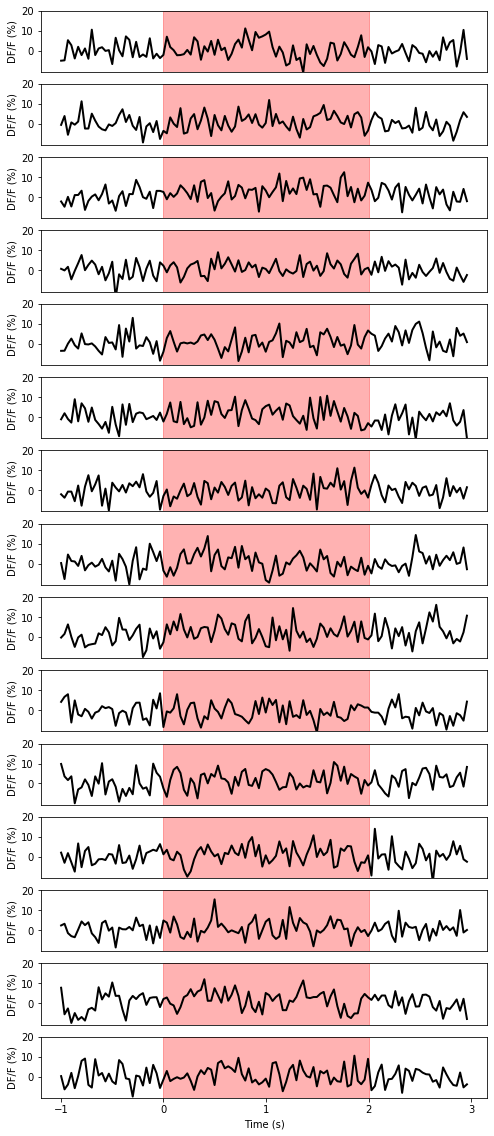

In [16]:
plt.figure(figsize=(8,20))
for i in range(len(subset)): # i 15 esperimenti
    plt.subplot(len(pref_trials),1,i+1) # seleziono il subplot (i+1)
    
    plt.plot(trial_timestamps, subset[str(cell_loc)].iloc[i], color='k', lw=2)
    
    plt.axvspan(0,2,color='red', alpha=0.3)
    plt.ylabel("DF/F (%)")
    plt.ylim(min(subset['dx'].iloc[1]) -5, max(subset['dx'].iloc[1]) + 5) #plt.ylim(-10,20) 
    plt.yticks(range(0,30,10))
    #plt.text(2.5, 300, str(round(subset_mean['dx'].iloc[i],2))+" cm/s")
    if i<(len(subset)-1):
        plt.xticks([])
    else:
        plt.xticks([-1,0,1,2,3])
        plt.xlabel("Time (s)")

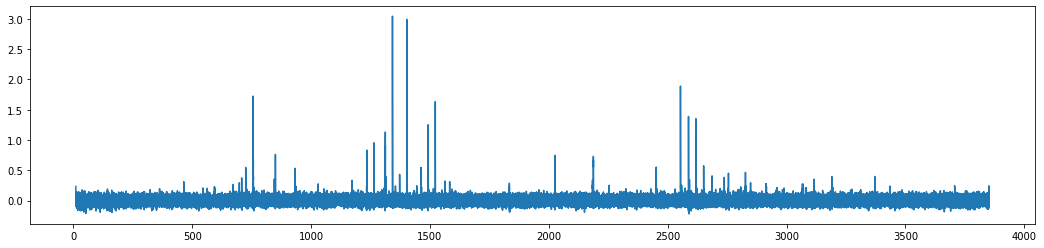

In [17]:
time, trace = experiment.get_dff_traces(cell_specimen_ids=[specimen_id])
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,4))
plt.plot(time, trace[0])

#plt.axvspan(dg.stim_table['start'].iloc[0], dg.stim_table['end'].iloc[0], color='red', alpha=0.3)

plt.show()

In [25]:
from numpy import asarray
from numpy import savetxt
savetxt('data.csv', trace[0], delimiter=',')

In [18]:
dg.stim_table.end - dg.stim_table.start
dg.stim_table

,temporal_frequency,orientation,blank_sweep,start,end
0,8.0,270.0,0.0,747,807
1,2.0,135.0,0.0,837,897
2,2.0,315.0,0.0,927,987
3,15.0,315.0,0.0,1018,1077
4,1.0,270.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,270.0,0.0,114837,114897
624,4.0,180.0,0.0,114928,114987
625,2.0,180.0,0.0,115018,115078
626,8.0,270.0,0.0,115108,115168
